<a href="https://colab.research.google.com/github/SarkarPriyanshu/Machine-Learning-Models/blob/main/Sentiments_Of_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install gdown -q
!pip install tensorflow-gpu -q

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install nltk -q

In [3]:
!pip install emoji -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros

import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.corpus import words

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer,one_hot
from keras.models import Sequential
from keras.layers import Flatten,Embedding,LSTM,SimpleRNN,Dense,SpatialDropout1D


import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Gathering and Assesment

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

100% 1.99M/1.99M [00:01<00:00, 2.22MB/s]
100% 1.99M/1.99M [00:01<00:00, 1.94MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('/content/twitter-entity-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
df = pd.read_csv('/content/twitter_training.csv',names=['sno','topic','sentiment','tweet'])

## Basic Analysis

In [12]:
df.shape

(74682, 4)

In [13]:
df.sample(5)

,sno,topic,sentiment,tweet
34877,6789,Fortnite,Irrelevant,He said told u I'm getting in that box of a br...
21704,4115,CS-GO,Positive,Yo this looks LIT! CS: GO / Overwatch combo
47008,5665,HomeDepot,Negative,@HomeDepot attention executive administrators....
7969,9369,Overwatch,Irrelevant,Guy has notified me and says that my name has ...
454,2476,Borderlands,Positive,F Loving the new DLC!!!. RhandlerR RhandlerR R...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sno        74682 non-null  int64 
 1   topic      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [15]:
df.isnull().sum() / df.shape[0] 

sno          0.000000
topic        0.000000
sentiment    0.000000
tweet        0.009186
dtype: float64

In [16]:
df.duplicated().sum()

2700

### Observation
   - Text columns have null values `0.009186` % of total samples.
   - data contain duplicated values  of around `2700` rows

## EDA

In [17]:
df = df.drop_duplicates(keep='first')

length of Irrelevant sentiment
Mean : 112.0748185371301


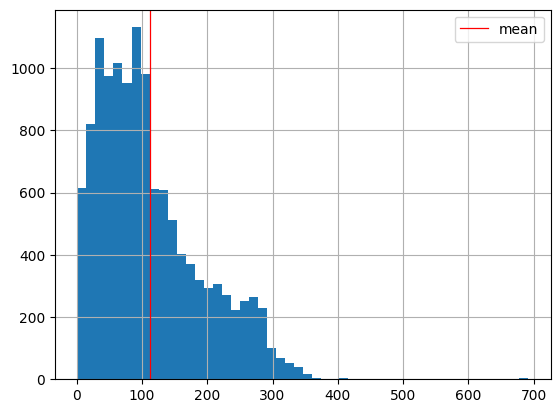


length of Negative sentiment
Mean : 113.42179002673058


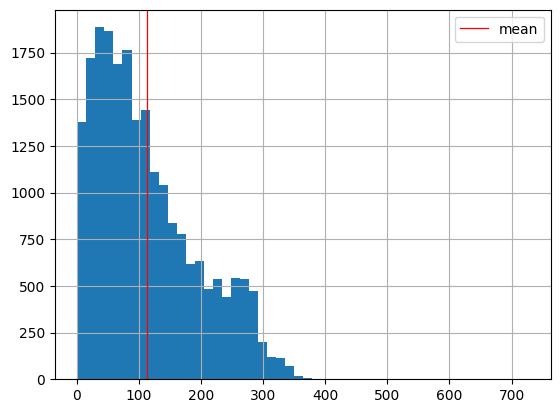


length of Neutral sentiment
Mean : 119.55184097583013


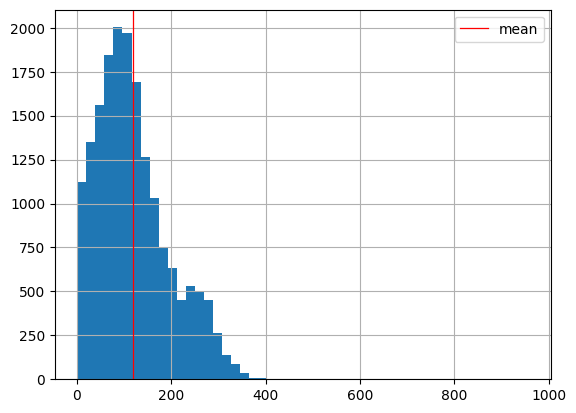


length of Positive sentiment
Mean : 98.28985948358951


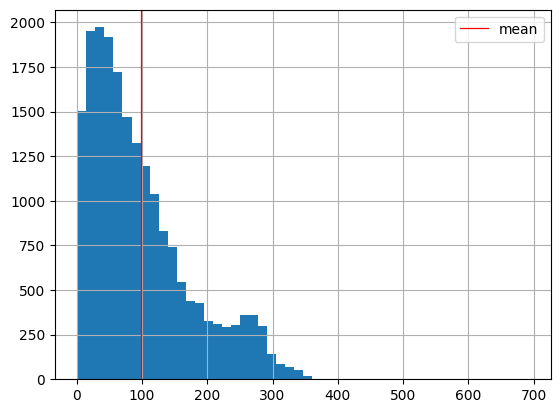

In [18]:
for sentiment,values in df.groupby('sentiment')['tweet']:
  print(f'length of {sentiment} sentiment')
  values.str.len().hist(bins=50)
  print(f'Mean : {np.mean(values.str.len())}')
  plt.axvline(x=np.mean(values.str.len()), linewidth=0.9, label= 'mean',color='red')
  plt.legend(loc = 'upper right')
  plt.show()
  print()

- Average length of tweet per sentiment
    - 50 to 150 average sentence length for `irrelivant` sentiment
    - 0 to 150 average sentence length for `Negative` sentiment
    - 60 to 180 average sentence length for `Neutral` sentiment
    - 40 to 80 average sentence length for `Positive` sentiment

In [19]:
text_lens = [len(t.split()) for t in df['tweet'].dropna().values]
len_mean = np.mean(text_lens)

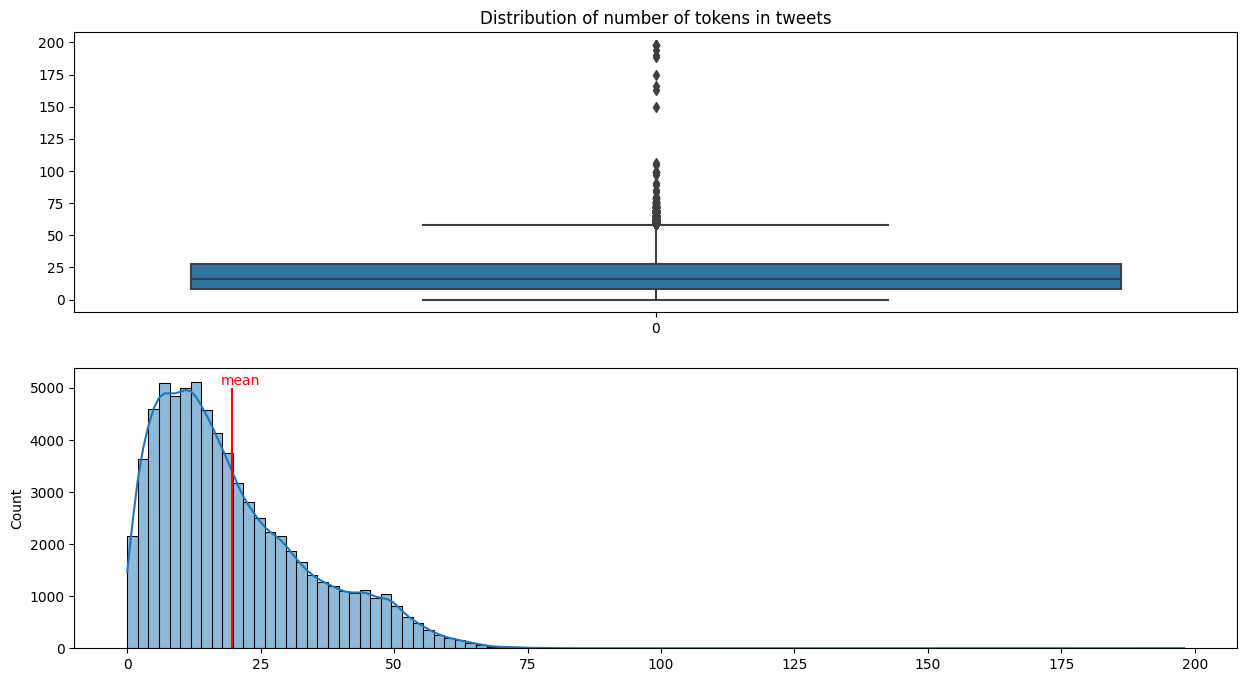

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 5000, color = 'r')
plt.annotate("mean", xy=(len_mean, 5000), xytext=(len_mean-2, 5050),
            color='r')
plt.show()

### Observation
  - Mean length of tweets is nearly 23 tokens. The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are clode to the right whisker but some are located far from the majority of points. Let investigate them!

In [21]:
extreme_outliers = df['tweet'].dropna()[np.array(text_lens) > 125]

In [22]:
for idx in extreme_outliers.index:
    print(idx, 'Target', df.dropna()['sentiment'][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

1826 Target Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

8546 Target Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

10454 Target Positive
_ _ _ _ _ _ 

### Observations
  - We can drop this outliers as they are not giving any insites.

In [23]:
df = df.dropna()[np.array(text_lens) < 125]

In [24]:
df.shape

(71645, 4)

<Axes: ylabel='sentiment'>

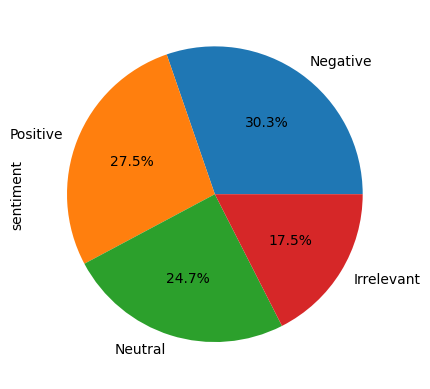

In [25]:
df['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')

### Observations
  - All target labels are balance no need to handle imbalance processing.

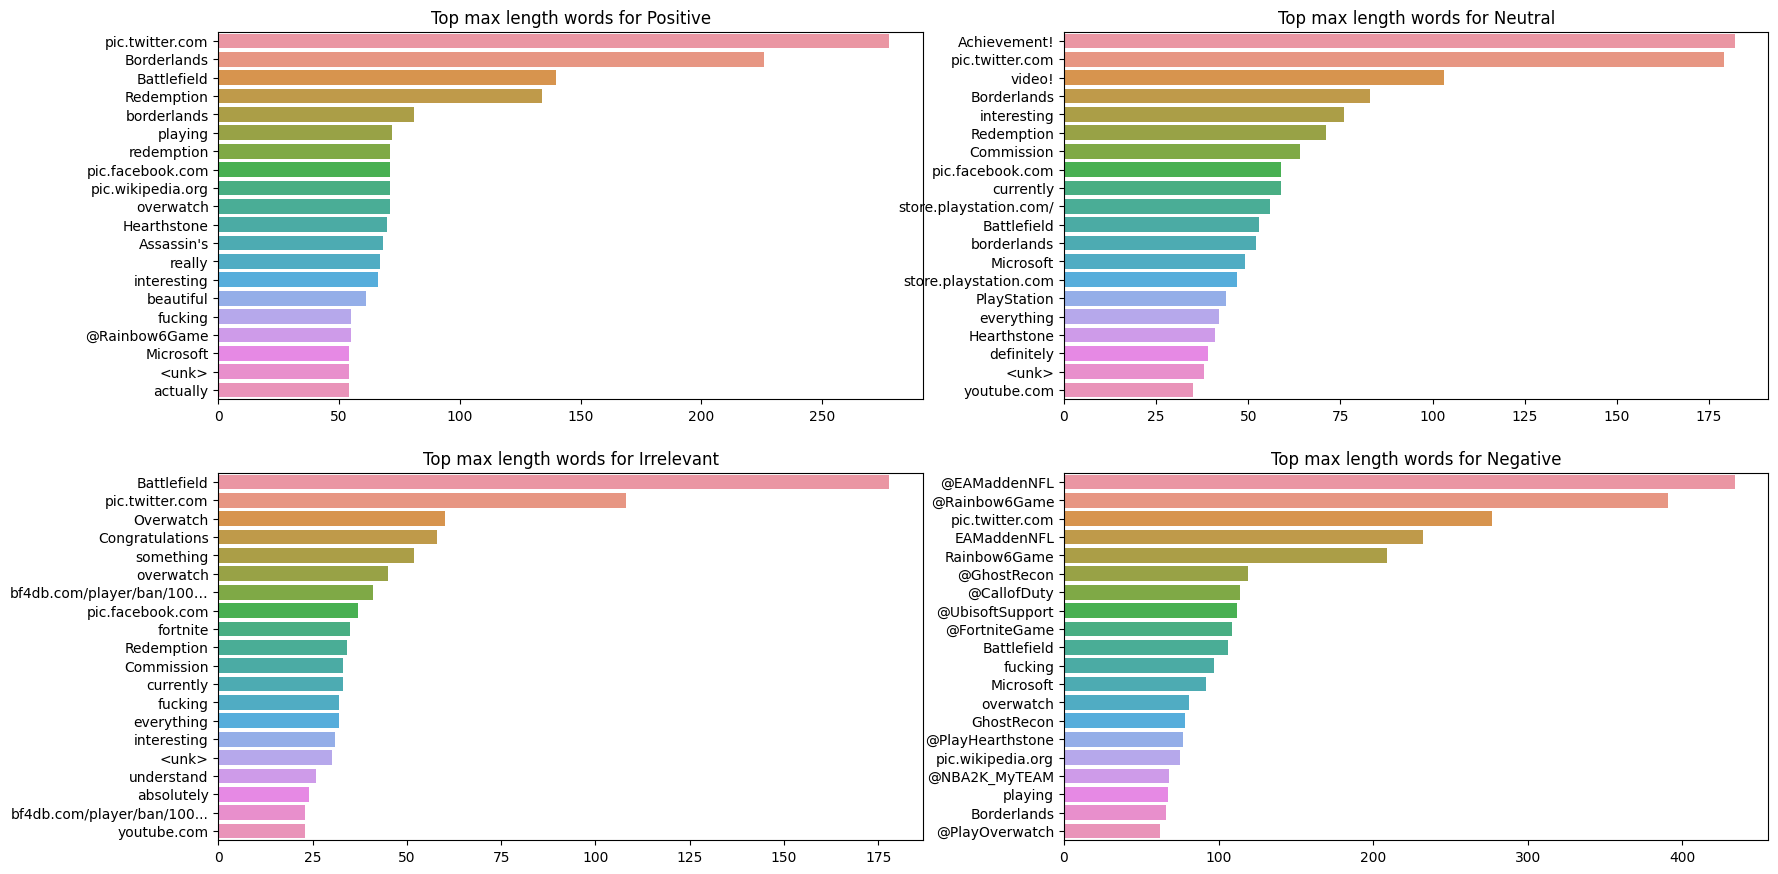

In [26]:
word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

for text, t in zip(df['tweet'], df['sentiment']):
    text = [(len(word.replace(r'[.(){}\/\[\]!@#$%^&*()_+=-]+', "")),word.replace(r'[.(){}\/\[\]!@#$%^&*()_+=-]+', "")) for word in text.split() if word not in stopwords.words('english') and len(word) < 50]
    if len(text) > 0:
      word_counts[t].append(max(text))

fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series([i[1] for i in words]).value_counts()[:20]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top max length words for {target}')
plt.show()

### Observation
  - Top occuring word for all four labels

In [27]:
word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(df['tweet'], df['sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords.words('english')]
    word_counts[t].extend(text)

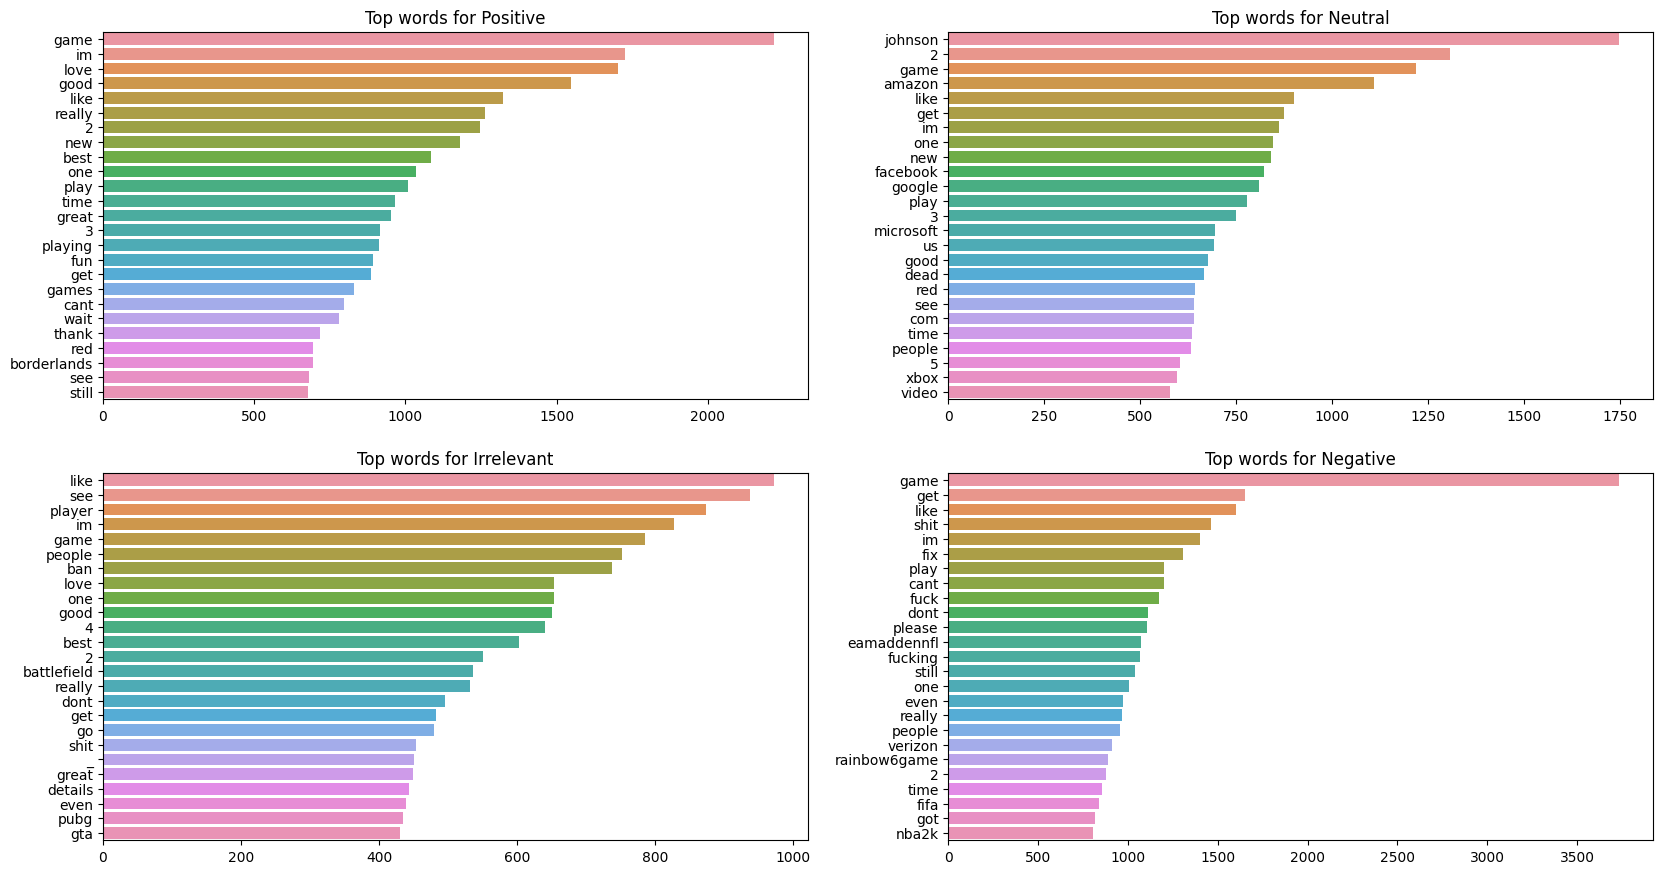

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

### Observation
  - We can see a clear difference between emotinal and neutral topics. In "Positive" top we can see some positive words, like love, good, best, great. In "Negative", instead, we observe lots of swear words. In neutral categories words with positive connotation are also observed, but not so frequent. To sum up, distribution of top-frequent words is different across target categories.

In [29]:
'BlackOpsColdWar 🤞 merci le lord' 
'Still my favorite CoD teaser EVER! 🥰'

'Still my favorite CoD teaser EVER! 🥰'

In [30]:
emoji.replace_emoji('BlackOpsColdWar 🤞 merci le lord' , replace=lambda chars, data_dict: chars.encode('unicode-escape').decode())

'BlackOpsColdWar \\U0001f91e merci le lord'

dict_keys(['🤯', '🤞', '🥺', '🤔', '🥵', '🤠', '🥳', '🤣', '🤑', '🤤', '🤩', '🥖', '🦊', '🙂', '3⃣', '🥴', '🤪', '🤖', '🤡', '🤓', '🧻', '🥘', '®', '🦾', '🤗', '™', '🧐', '⏳', '🤫'])


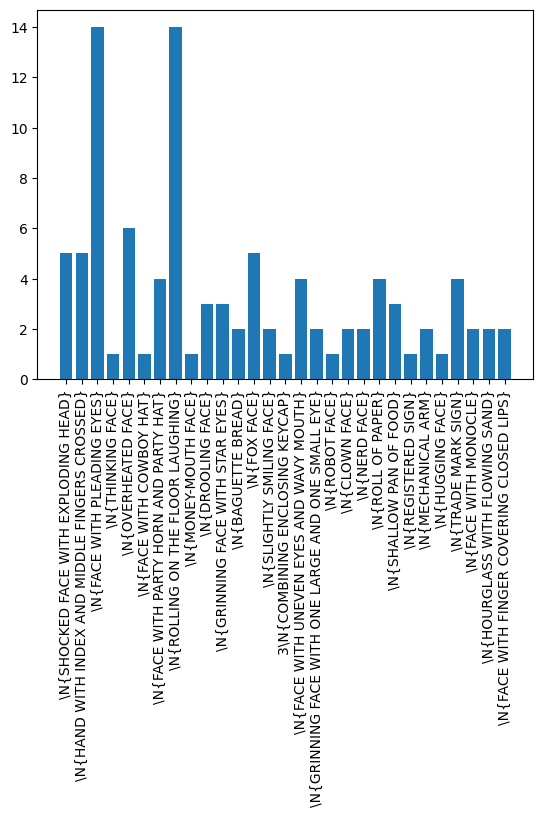

dict_keys(['🧨', '™', '🤠', '©', '🤔', '🦊', '🧐', '🤡', '🧹', '🤬', '®', '1⃣', '2⃣', '3⃣', '4⃣', '5⃣', '6⃣', '🤣', '🦾', '🥰', '🤨', '🤯', '🧠', '🧀', '🤖'])


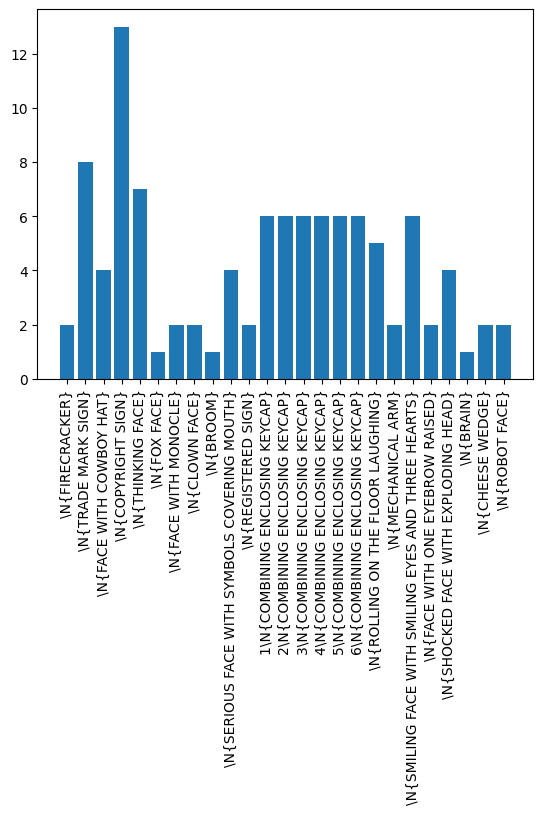

dict_keys(['🤔', '🤞', '🤢', '🤡', '🤣', '🥰', '🤪', '🥴', '©', '🥄', '🤛', '🤓', '🤗', '🥺', '🦋', '🥳', '®', '🤩', '2⃣', '🥵', '🤐', '🙂', '🤍', '🤨', '🧐'])


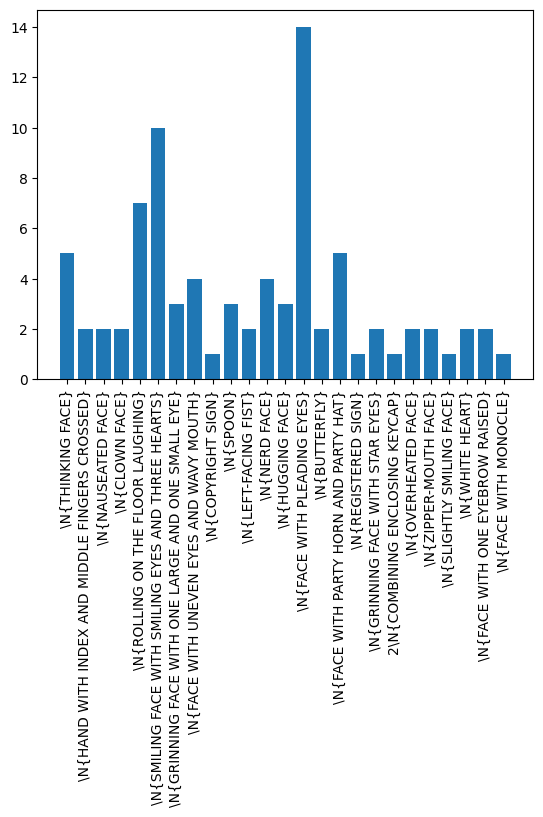

dict_keys(['🥴', '🤣', '🥺', '🤔', '©', '🙂', '🤬', '🤡', '🤧', '🥵', '🥰', '™', '🤨', '🤑', '🥳', '🤝', '🤠'])


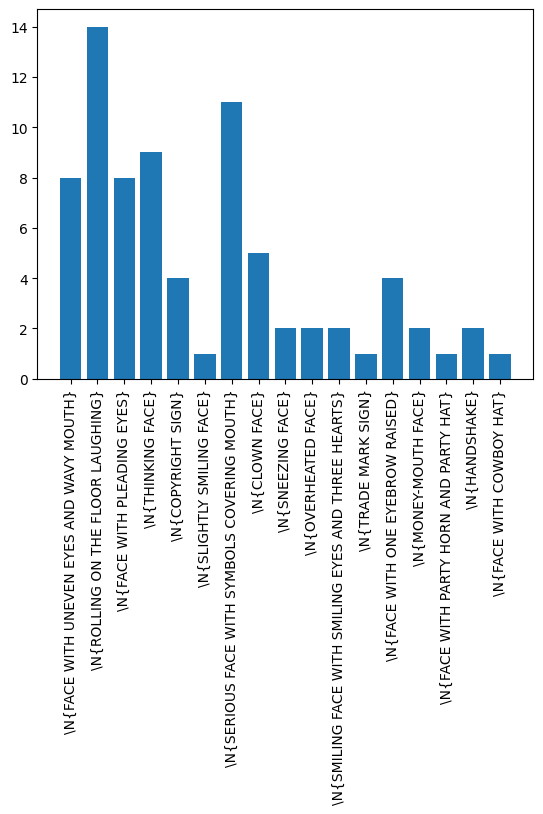

In [31]:
emoji_counts = {'Positive': {},
                'Neutral': {},
                'Irrelevant': {},
                'Negative': {}}

for text, t in zip(df['tweet'], df['sentiment']):
   for word in text.split():
     if emoji.is_emoji(word):
        if word not in emoji_counts[t]:
            emoji_counts[t][word] = 1
        else:
             emoji_counts[t][word] = emoji_counts[t][word] + 1         

for axis, (target, words) in zip(axes.flatten(), emoji_counts.items()):
    print(words.keys())
    values = words.values()
    keys = [emoji.replace_emoji(value, replace=lambda chars, data_dict: chars.encode('ascii', 'namereplace').decode()) for value in words.keys()]
    plt.bar(x = keys, height = values)
    plt.xticks(rotation = 90)
    axis.set_title(f'Top emoji for {target}')
    plt.show()

### Observation 
  - Different emojis also help in predicting the emotion of a tweet so we can replace this emojies with unicode formate

### Preprocessing Steps
  - Handle text under html tags `<>`
  - tweets having special character `!@#$$%^^&*()_+-=<>`
  - tweets have words with specail character at the end `ove!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!`
  - incorrect spelling and fast typing issues
  - text normalisation required
  - text having hyperlinks
  - text have emogies need to convert them in understandable format
  - tokenisation
  - stopward removal
  - puntuation removal

## Feature Preprocessing and Engineering

In [32]:
# self defined contractions
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks"
        }

### Basic Preprocessing

In [33]:
def preprocessing(df,independent_feature):
  new_df = df.copy()
  independent = df[independent_feature].copy()

  # normalising the text for preprocessing
  independent = independent.str.lower()

  # Handling html tags present in text
  clean = re.compile('<.*?>')
  independent = independent.apply(lambda text:re.sub(clean, '', text))

  # Remove "@" from mentions
  independent = independent.apply(lambda text:re.sub(r'@([A-Za-z0-9_]+)', r'\1', text))

  # Remove "#" from hashtags
  independent = independent.apply(lambda text:re.sub(r'#([A-Za-z0-9_]+)', r'\1', text))

  # Remove hyperlinks
  independent = independent.apply(lambda text:re.sub(r'http\S+', '', text))

  # Remove continuous sequence of special characters at the end of the text
  independent = independent.apply(lambda text:re.sub(r'[^\w\s]|(\s+[^\w\s])+$', '', text))  

  # Remove Puntuations
  independent = independent.apply(lambda text:re.sub("[\.\,\!\?\:\;\-\=]", '', text))
  
  # replacing emoji
  independent = independent.apply(lambda text:emoji.replace_emoji(text, replace=lambda chars ,data_dict:chars.encode('ascii', 'xmlcharrefreplace').decode()))

   # replacing emoji
  independent = independent.apply(lambda text:" ".join([load_dict_contractions()[word] if word in load_dict_contractions() else word for word in text.split()]))

  # Remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
  independent = independent.apply(lambda text:pattern.sub('', text))

  new_df[independent_feature] = independent

  return new_df
  

In [34]:
new_df = preprocessing(df,'tweet')

In [35]:
y =  new_df['sentiment'].map({key:index for index,key in enumerate(new_df['sentiment'].unique())})
X = new_df['tweet']

## Model Bulding

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((57316,), (14329,), (57316,), (14329,))

### Embedding Layer 

In [38]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [39]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

36592

In [40]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [41]:
# Load GloVe word embeddings and create an Embeddings Dictionary
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [42]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [43]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [44]:
embedding_matrix.shape

(36592, 100)

## Model Training with:Simple Recurrent Neural Network

In [45]:
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen)
model.add(embedding_layer)
model.add(SimpleRNN(32,return_sequences=False))
model.add(Dense(4, activation='softmax'))

In [46]:
# Model compiling

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          3659200   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 3,663,588
Trainable params: 3,663,588
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
1792/1792 [==============================] - 282s 154ms/step - loss: 1.3693 - acc: 0.2991 - val_loss: 1.3676 - val_acc: 0.3028
Epoch 2/10
1792/1792 [==============================] - 233s 130ms/step - loss: 1.3693 - acc: 0.2979 - val_loss: 1.3679 - val_acc: 0.3029
Epoch 3/10
1792/1792 [==============================] - 225s 125ms/step - loss: 1.3685 - acc: 0.3002 - val_loss: 1.3715 - val_acc: 0.2996
Epoch 4/10
1792/1792 [==============================] - 221s 123ms/step - loss: 1.3699 - acc: 0.2990 - val_loss: 1.3702 - val_acc: 0.3029
Epoch 5/10
1792/1792 [==============================] - 225s 126ms/step - loss: 1.3694 - acc: 0.2987 - val_loss: 1.3678 - val_acc: 0.3011
Epoch 6/10
1792/1792 [==============================] - 217s 121ms/step - loss: 1.3686 - acc: 0.2987 - val_loss: 1.3676 - val_acc: 0.3028
Epoch 7/10
1792/1792 [==============================] - 224s 125ms/step - loss: 1.3678 - acc: 0.3028 - val_loss: 1.3672 - val_acc: 0.3028
Epoch 8/10
1792/1792 [============

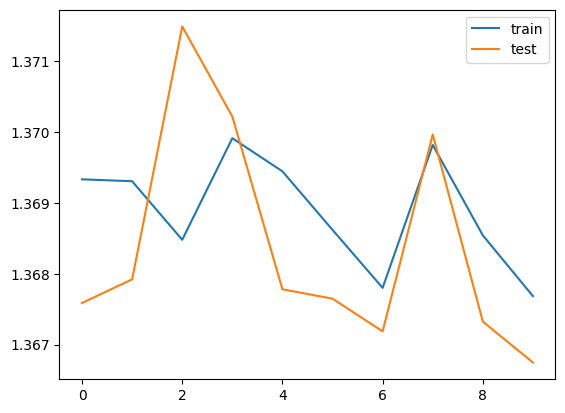

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

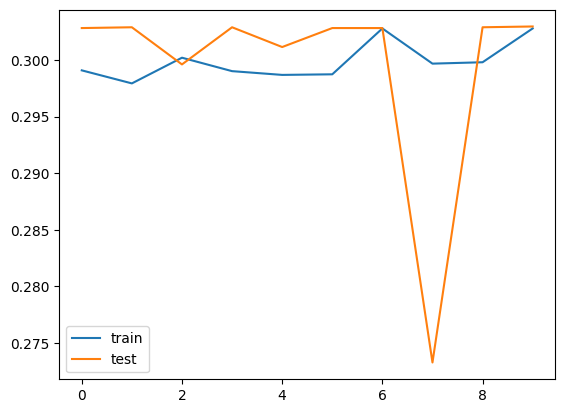

In [49]:


plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

## Model Training with:LSTM

In [50]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(4, activation='softmax'))

In [51]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          3659200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 3,776,964
Trainable params: 3,776,964
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test))

Epoch 1/10
1792/1792 [==============================] - 44s 22ms/step - loss: 1.3687 - acc: 0.3014 - val_loss: 1.3673 - val_acc: 0.3029
Epoch 2/10
1792/1792 [==============================] - 22s 12ms/step - loss: 1.3678 - acc: 0.3028 - val_loss: 1.3668 - val_acc: 0.3029
Epoch 3/10
1792/1792 [==============================] - 18s 10ms/step - loss: 1.3679 - acc: 0.3028 - val_loss: 1.3670 - val_acc: 0.3029
Epoch 4/10
1792/1792 [==============================] - 19s 10ms/step - loss: 1.3677 - acc: 0.3028 - val_loss: 1.3666 - val_acc: 0.3029
Epoch 5/10
1792/1792 [==============================] - 19s 10ms/step - loss: 1.3677 - acc: 0.3028 - val_loss: 1.3666 - val_acc: 0.3029
Epoch 6/10
1792/1792 [==============================] - 18s 10ms/step - loss: 1.3677 - acc: 0.3025 - val_loss: 1.3667 - val_acc: 0.3030
Epoch 7/10
1792/1792 [==============================] - 19s 10ms/step - loss: 1.3676 - acc: 0.3028 - val_loss: 1.3669 - val_acc: 0.3029
Epoch 8/10
1792/1792 [==========================

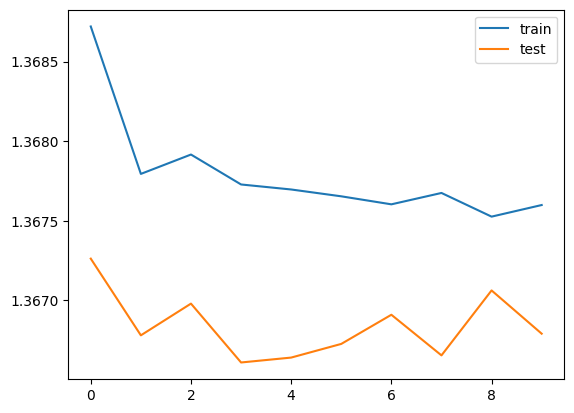

In [53]:
plt.plot(lstm_model_history.history['loss'], label='train')
plt.plot(lstm_model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

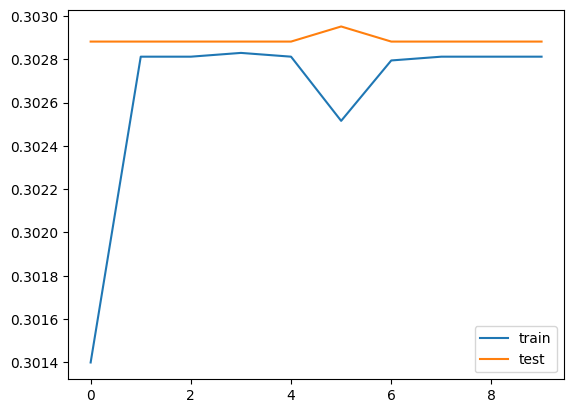

In [54]:


plt.plot(lstm_model_history.history['acc'], label='train')
plt.plot(lstm_model_history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [55]:
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_test = keras.utils.to_categorical(y_test, num_classes=4)

In [56]:
# Neural Network architecture

lstm_2_model = Sequential()
lstm_2_model.add(Embedding(vocab_length, 100,input_length = maxlen))
lstm_2_model.add(LSTM(100,dropout=0.25,recurrent_dropout=0.25))
lstm_2_model.add(Dense(50,activation='relu'))
lstm_2_model.add(Dense(25,activation='relu'))
lstm_2_model.add(Dense(4, activation='softmax'))


In [57]:


# Model compiling
lstm_2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

print(lstm_2_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          3659200   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 4)                 104       
                                                                 
Total params: 3,746,029
Trainable params: 3,746,029
Non-trainable params: 0
_________________________________________________________________
None
